In [1]:
# This file contains readers for the data used in the project
import pandas as pd

# Data sources
# Electricity: https://porssisahko.net/tilastot
# Weather: https://www.ilmatieteenlaitos.fi/havaintojen-lataus
ep_df = pd.read_excel("Electricity_price-010121-220924.xlsx", header = 3)   # Some useless rows at the beginning of the file
ws_df = pd.read_excel('Kalajoki_Ulkokalla_wind_010121-210924.xlsx') 

print(ep_df.head())
print(50*"-")
print(ws_df.head())


                 Aika  Hinta (snt/kWh)
0 2021-01-01 00:59:11            3.094
1 2021-01-01 01:59:11            3.019
2 2021-01-01 02:59:11            2.974
3 2021-01-01 03:59:11            2.941
4 2021-01-01 04:59:11            2.943
--------------------------------------------------
        Havaintoasema  Vuosi  Kuukausi  Päivä Aika [Paikallinen aika]  \
0  Kalajoki Ulkokalla   2021         1      1                   00:00   
1  Kalajoki Ulkokalla   2021         1      1                   01:00   
2  Kalajoki Ulkokalla   2021         1      1                   02:00   
3  Kalajoki Ulkokalla   2021         1      1                   03:00   
4  Kalajoki Ulkokalla   2021         1      1                   04:00   

  Keskituulen nopeus [m/s] Lämpötilan keskiarvo [°C]  
0                      6.2                         1  
1                      5.6                       0.8  
2                      4.8                       0.7  
3                        5                       0.5  
4

In [2]:
# Format the time column of the dataframes to match one another
from datetime import timedelta

ep_df['Aika'] = ep_df['Aika'] + timedelta(seconds=49)
print(ep_df.head())
print(50*"-")

# Rename wind data time columns to enable application of to_datetime call
ws_df['Aika [Paikallinen aika]'] = ws_df['Aika [Paikallinen aika]'].apply(lambda x: int(x.split(":")[0]))
ws_df.rename(columns={'Vuosi': 'year', 'Kuukausi': 'month', 'Päivä': 'day', 'Aika [Paikallinen aika]': 'hour'}, inplace=True)

ws_df['Aika'] = pd.to_datetime(ws_df[['year', 'month', 'day', 'hour']])
# Remove the now obsolete time-related columns
ws_df.drop(['year','month','day','hour'], axis=1, inplace=True)

print(ws_df.head())

                 Aika  Hinta (snt/kWh)
0 2021-01-01 01:00:00            3.094
1 2021-01-01 02:00:00            3.019
2 2021-01-01 03:00:00            2.974
3 2021-01-01 04:00:00            2.941
4 2021-01-01 05:00:00            2.943
--------------------------------------------------
        Havaintoasema Keskituulen nopeus [m/s] Lämpötilan keskiarvo [°C]  \
0  Kalajoki Ulkokalla                      6.2                         1   
1  Kalajoki Ulkokalla                      5.6                       0.8   
2  Kalajoki Ulkokalla                      4.8                       0.7   
3  Kalajoki Ulkokalla                        5                       0.5   
4  Kalajoki Ulkokalla                      4.6                       0.4   

                 Aika  
0 2021-01-01 00:00:00  
1 2021-01-01 01:00:00  
2 2021-01-01 02:00:00  
3 2021-01-01 03:00:00  
4 2021-01-01 04:00:00  


In [3]:
# Merge the two data sets
df = pd.merge(ep_df, ws_df, on='Aika', how='inner')
print(df.head())

                 Aika  Hinta (snt/kWh)       Havaintoasema  \
0 2021-01-01 01:00:00            3.094  Kalajoki Ulkokalla   
1 2021-01-01 02:00:00            3.019  Kalajoki Ulkokalla   
2 2021-01-01 03:00:00            2.974  Kalajoki Ulkokalla   
3 2021-01-01 04:00:00            2.941  Kalajoki Ulkokalla   
4 2021-01-01 05:00:00            2.943  Kalajoki Ulkokalla   

  Keskituulen nopeus [m/s] Lämpötilan keskiarvo [°C]  
0                      5.6                       0.8  
1                      4.8                       0.7  
2                        5                       0.5  
3                      4.6                       0.4  
4                      4.9                       0.4  


In [4]:
# Imputation

# First we need to change the types of columns, e.g., numerical values into float
print("Column types before transformation")
print(df.dtypes)    # Which columns need to be retyped?

# use to_numeric and coerce errors as nan values
df['Keskituulen nopeus [m/s]'] = pd.to_numeric(df['Keskituulen nopeus [m/s]'], errors='coerce')
df['Lämpötilan keskiarvo [°C]'] = pd.to_numeric(df['Lämpötilan keskiarvo [°C]'], errors='coerce')
print("\nColumn types after transformation")
print(df.dtypes)

# Keep it simple, replace missing values with column median
nan_count = df.isna().sum()
print("\nNAN check for columns:")
print(nan_count)
# Wind speed and temperature need imputation
df[['Keskituulen nopeus [m/s]', 'Lämpötilan keskiarvo [°C]']] = df[['Keskituulen nopeus [m/s]', 'Lämpötilan keskiarvo [°C]']].fillna(df[['Keskituulen nopeus [m/s]', 'Lämpötilan keskiarvo [°C]']].median())

Column types before transformation
Aika                         datetime64[ns]
Hinta (snt/kWh)                     float64
Havaintoasema                        object
Keskituulen nopeus [m/s]             object
Lämpötilan keskiarvo [°C]            object
dtype: object

Column types after transformation
Aika                         datetime64[ns]
Hinta (snt/kWh)                     float64
Havaintoasema                        object
Keskituulen nopeus [m/s]            float64
Lämpötilan keskiarvo [°C]           float64
dtype: object

NAN check for columns:
Aika                           0
Hinta (snt/kWh)                0
Havaintoasema                  0
Keskituulen nopeus [m/s]     109
Lämpötilan keskiarvo [°C]      1
dtype: int64


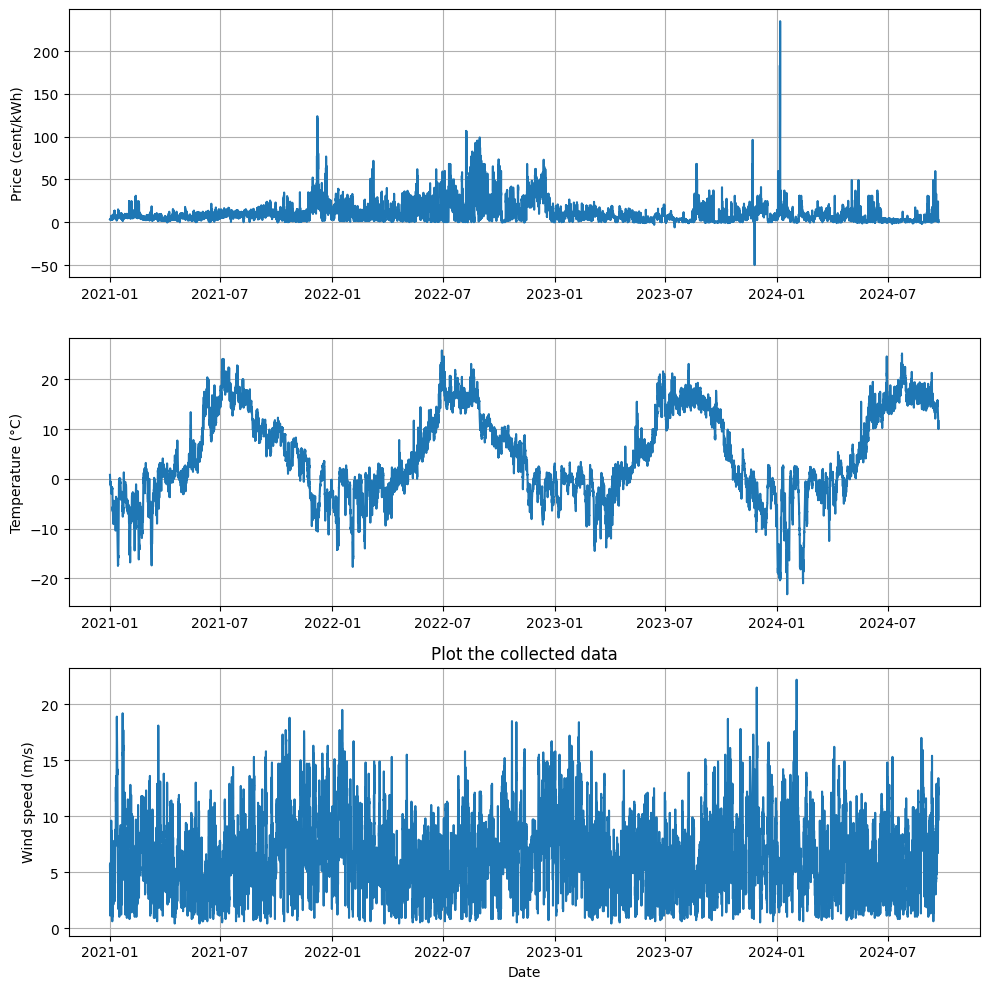

In [9]:
# Do some plotting
import matplotlib.pyplot as plt

if df.index.name is None:
    # Set the index of the dataframe
    df.set_index('Aika', inplace=True)

N_ROWS = 3  # price, wind, temp
fig, axs = plt.subplots(nrows=N_ROWS, ncols=1, figsize=(10,10))

axs[0].plot(df.index,  df['Hinta (snt/kWh)'], label='Price')
axs[0].set_ylabel('Price (cent/kWh)')
axs[0].grid(True)

axs[1].plot(df.index, df['Lämpötilan keskiarvo [°C]'], label='Temperature avg.')
axs[1].set_ylabel('Temperature (°C)')
axs[1].grid(True)

axs[2].plot(df.index, df['Keskituulen nopeus [m/s]'], label='Temperature avg.')
axs[2].set_ylabel('Wind speed (m/s)')
axs[2].set_xlabel('Date')
axs[2].grid(True)

plt.title('Plot the collected data')
plt.tight_layout()
plt.show()